# Atlanta NOTAM Data Info

## Introduction
NOTAM stands for "Notice to Airmen" and describes messages concerning the state of an airport or other important messages for pilots.
Data has been gathered from: __[https://notams.aim.faa.gov/notamSearch/nsapp.html#/](https://notams.aim.faa.gov/notamSearch/nsapp.html#/)__

Explanation of NOTAM text: __[https://www.faa.gov/about/initiatives/notam/what_is_a_notam/media/Pilots_NOTAM_primer_for_2021.pdf](https://www.faa.gov/about/initiatives/notam/what_is_a_notam/media/Pilots_NOTAM_primer_for_2021.pdf)__

NOTAM NLP paper: __[https://aviationsystems.arc.nasa.gov/publications/2021/20210017786_Clarke_Aviation2021.pdf](https://aviationsystems.arc.nasa.gov/publications/2021/20210017786_Clarke_Aviation2021.pdf)__

Approved NOTAM contractions: __[https://www.notams.faa.gov/downloads/contractions.pdf](https://www.notams.faa.gov/downloads/contractions.pdf)__


## Dropped
- Cancel Date (No Use)
- Effective Date (No Use)
- Expiration Date (No Use)
- Location (Redundant)
- NOTA # (No Use)


# Global Variables

In [41]:
import pandas as pd
import glob
import re
import numpy as np
import os

from pandas import date_range

from main.utils.data_manage_utils import read_table_from_subfolder
# Variables
ROOT_PATH = os.path.abspath("../../")
INPUT_FOLDER = os.path.join(ROOT_PATH, "data/input")
OUTPUT_FOLDER = os.path.join(ROOT_PATH, "data/preparation/prepped_files")

# Data Loading

NOTAM data is stored in various files for the katl airport. Somehow the separator for these varies between files with 5 being separated by ";" and 360 with ",".
Therefore, the below if branches are needed to transform the information stored in .csv files into Pandas DataFrames. 

Additionally, 336 of the input .csv files included text headings with filter options which, when loaded, added a misfitting header and resulted in feature columns named "Unnamed: x" where x indicated the position in the .csv file. The unnamed columns are created by the loading process of pandas, since a seperator is found, but the header does not have further feature names. 
This is fixed by incrementally skipping columns until the correct header line is found resulting in no "Unnamed: x" columns. At this point the data is loaded correctly. 
Simply including a fixed threshold to find the correct header line was not sufficient, since the line varied from file to file. 

In [42]:
all_files = glob.glob(os.path.join(INPUT_FOLDER, "data_raw/notams/katl/*/*.csv"))

li = []
comma_sep = 0
semi_sep = 0
wrong_head = 0
for filename in all_files:
    df = pd.read_csv(filename, sep=";", on_bad_lines="skip")
    if len(df.columns) <= 1:
        df = pd.read_csv(filename, sep=",", on_bad_lines="skip")
        comma_sep +=1
    else:
        semi_sep += 1
    if any("Unnamed" in col for col in df.columns):
        wrong_head += 1
        done = False
        count = 0
        while not done:
            df = pd.read_csv(filename, on_bad_lines="skip", header = count)
            if not any("Unnamed" in col for col in df.columns):
                done = True
            count += 1
    li.append(df)
li
atl_notam_df = pd.concat(li, axis=0, ignore_index=True)
atl_notam_df

,Location,NOTAM #,Class,Issue Date (UTC),Effective Date (UTC),Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject
0,ATL,04/107,Communication,04/19/2016 1648,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
1,ATL,6/4595,Procedure,12/22/2016 2135,12/23/2016 1000,NaN,08/17/2017 1000,!FDC 6/4595 ATL CANCELLED BY FDC 7/3089 ON 08/...
2,ATL,6/4598,Procedure,12/22/2016 2135,12/23/2016 1000,NaN,08/17/2017 1000,!FDC 6/4598 ATL CANCELLED BY FDC 7/3090 ON 08/...
3,ATL,6/4601,Procedure,12/22/2016 2135,12/23/2016 1000,NaN,08/17/2017 1000,!FDC 6/4601 ATL CANCELLED BY FDC 7/3088 ON 08/...
4,ATL,6/4603,Procedure,12/22/2016 2136,12/23/2016 1000,NaN,08/17/2017 1000,!FDC 6/4603 ATL CANCELLED BY FDC 7/3091 ON 08/...
...,...,...,...,...,...,...,...,...
16158,ATL,11/142,Obstruction,11/16/2017 1500,11/16/2017 1500,02/23/2018 1644,02/27/2018 2359,!ATL 11/142 ATL OBST TOWER LGT (ASR 1022036) 3...
16159,ATL,7/5192,Procedure,10/16/2017 1355,10/17/2017 0500,NaN,02/01/2018 0900,!FDC 7/5192 ATL CANCELLED BY FDC 8/4084 ON 02/...
16160,ATL,12/231,Obstruction,12/18/2017 1317,12/18/2017 1316,01/17/2018 0703,01/17/2018 1200,!ATL 12/231 ATL OBST TOWER LGT (ASR 1047185) 3...
16161,ATL,12/308,Aerodrome,12/28/2017 2301,12/28/2017 2301,01/03/2018 0619,01/12/2018 2301,!ATL 12/308 ATL AD AP ABN OUT OF SERVICE 17122...


In [43]:
print(f"Number comma separated: {comma_sep}")
print(f"Number semicolon separated: {semi_sep}")
print(f"Number misaligned headers: {wrong_head}")

Number comma separated: 360
Number semicolon separated: 5
Number misaligned headers: 336


# Filtering for "RWY" and "FICON"

Runway and Field Condition concerning NOTAMs seem to be the most interesting for carrier delay information. Also information found with these NOTAM classes was easier recognizable and did not require NLP.

In [44]:
_series = atl_notam_df["NOTAM Condition or LTA Subject"]
_filtered = _series[_series.str.contains("RWY") & ~_series.str.contains("FICON")]
_filtered

9        !FDC 6/2007 ATL STAR HARTSFIELD-JACKSON ATLANT...
10       !FDC 6/2008 ATL STAR HARTSFIELD-JACKSON ATLANT...
15       !FDC 6/3876 ATL IAP HARTSFIELD - JACKSON ATLAN...
16       !FDC 6/3038 ATL IAP HARTSFIELD - JACKSON ATLAN...
17       !FDC 6/3036 ATL IAP HARTSFIELD - JACKSON ATLAN...
                               ...                        
16144    !ATL 12/309 ATL NAV ILS RWY 26L MM NOT MNT 171...
16145    !ATL 12/289 ATL RWY 08L ALS NOT MNT 1712251342...
16147    !FDC 7/0431 ATL IAP HARTSFIELD - JACKSON ATLAN...
16154    !ATL 12/309 ATL NAV ILS RWY 26L MM NOT MNT 171...
16156    !FDC 7/0431 ATL IAP HARTSFIELD - JACKSON ATLAN...
Name: NOTAM Condition or LTA Subject, Length: 6192, dtype: object

# Date Time Handling

NOTAM times are stored with the format "MM/DD/YYYY hhmm". To make further processing possible, these are transformed to two separate columns with date and time respectively by simply spliting by space.


## Effective Date Splitting

In [45]:
eff_date = atl_notam_df["Effective Date (UTC)"].apply(lambda x: x.split()[0])
eff_time = atl_notam_df["Effective Date (UTC)"].apply(lambda x: x.split()[1])
eff_date_time = pd.concat([eff_date, eff_time], axis='columns')
eff_date_time.columns = ["NOTAM_Effective_Date","NOTAM_Effective_Time"]
atl_notam_df = pd.concat([atl_notam_df, eff_date_time], axis="columns").drop(columns=["Effective Date (UTC)"], axis = "columns")
atl_notam_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject,NOTAM_Effective_Date,NOTAM_Effective_Time
0,ATL,04/107,Communication,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...,04/19/2016,1648
1,ATL,6/4595,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4595 ATL CANCELLED BY FDC 7/3089 ON 08/...,12/23/2016,1000
2,ATL,6/4598,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4598 ATL CANCELLED BY FDC 7/3090 ON 08/...,12/23/2016,1000
3,ATL,6/4601,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4601 ATL CANCELLED BY FDC 7/3088 ON 08/...,12/23/2016,1000
4,ATL,6/4603,Procedure,12/22/2016 2136,NaN,08/17/2017 1000,!FDC 6/4603 ATL CANCELLED BY FDC 7/3091 ON 08/...,12/23/2016,1000
...,...,...,...,...,...,...,...,...,...
16158,ATL,11/142,Obstruction,11/16/2017 1500,02/23/2018 1644,02/27/2018 2359,!ATL 11/142 ATL OBST TOWER LGT (ASR 1022036) 3...,11/16/2017,1500
16159,ATL,7/5192,Procedure,10/16/2017 1355,NaN,02/01/2018 0900,!FDC 7/5192 ATL CANCELLED BY FDC 8/4084 ON 02/...,10/17/2017,0500
16160,ATL,12/231,Obstruction,12/18/2017 1317,01/17/2018 0703,01/17/2018 1200,!ATL 12/231 ATL OBST TOWER LGT (ASR 1047185) 3...,12/18/2017,1316
16161,ATL,12/308,Aerodrome,12/28/2017 2301,01/03/2018 0619,01/12/2018 2301,!ATL 12/308 ATL AD AP ABN OUT OF SERVICE 17122...,12/28/2017,2301


## Expiration Date Splitting

### Filtering Permanent NOTAMS

Some NOTAMS include "PERM" in the expiration date column which indicates a never ending scenario.
These are not relevant for our classification task and would additionally reduce variance in the data. Therefore, they are discarded. 

They are identified by simply not having a space character in the field. 

In [46]:
perm_notams = atl_notam_df[[False if ' ' in row else True for row in atl_notam_df["Expiration Date (UTC)"]]]
perm_notams

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject,NOTAM_Effective_Date,NOTAM_Effective_Time
0,ATL,04/107,Communication,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...,04/19/2016,1648
25,ATL,6/9742,Chart,12/09/2016 1706,01/05/2017 1210,PERM,!FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...,12/09/2016,1706
26,ATL,6/5812,Chart,11/10/2016 1203,01/05/2017 1200,PERM,!FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...,11/10/2016,1203
40,ATL,04/107,Communication,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...,04/19/2016,1648
65,ATL,6/9742,Chart,12/09/2016 1706,01/05/2017 1210,PERM,!FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...,12/09/2016,1706
...,...,...,...,...,...,...,...,...,...
16138,ATL,10/257,Communication,10/22/2017 1823,03/06/2018 1625,PERM,!ATL 10/257 ATL COM CPDLC DEP CLR LOGON CHANGE...,10/22/2017,1823
16146,ATL,04/107,Communication,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...,04/19/2016,1648
16148,ATL,10/257,Communication,10/22/2017 1823,03/06/2018 1625,PERM,!ATL 10/257 ATL COM CPDLC DEP CLR LOGON CHANGE...,10/22/2017,1823
16155,ATL,04/107,Communication,04/19/2016 1648,NaN,PERM,!ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...,04/19/2016,1648


In [47]:
print(f"Out of {len(atl_notam_df)}, {len(perm_notams)} are permanent.")
perm_notams["Expiration Date (UTC)"].value_counts()

Out of 16163, 2154 are permanent.


PERM    2154
Name: Expiration Date (UTC), dtype: int64

In [48]:
perm_notams["Class"].value_counts()

Procedure        1710
Communication     434
Chart              10
Name: Class, dtype: int64

In [49]:
print("Communication NOTAMs:")
perm_notams[perm_notams["Class"] == "Communication"]["NOTAM Condition or LTA Subject"]

Communication NOTAMs:


0        !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
40       !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
79       !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
118      !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
154      !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
                               ...                        
16138    !ATL 10/257 ATL COM CPDLC DEP CLR LOGON CHANGE...
16146    !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
16148    !ATL 10/257 ATL COM CPDLC DEP CLR LOGON CHANGE...
16155    !ATL 04/107 ATL COM REMOTE TRANSMITTER/RECEIVE...
16157    !ATL 10/257 ATL COM CPDLC DEP CLR LOGON CHANGE...
Name: NOTAM Condition or LTA Subject, Length: 434, dtype: object

In [50]:
print("Chart NOTAMs")
perm_notams[perm_notams["Class"] == "Chart"]["NOTAM Condition or LTA Subject"]

Chart NOTAMs


25     !FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...
26     !FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...
65     !FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...
66     !FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...
104    !FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...
105    !FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...
143    !FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...
144    !FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...
189    !FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATL...
190    !FDC 6/5812 ATL CHART HARTSFIELD - JACKSON ATL...
Name: NOTAM Condition or LTA Subject, dtype: object

In [51]:
print("Procedure NOTAMs")
perm_notams[perm_notams["Class"] == "Procedure"]["NOTAM Condition or LTA Subject"]

Procedure NOTAMs


6377     !FDC 7/8998 ATL IAP HARTSFIELD - JACKSON ATLAN...
6378     !FDC 7/8999 ATL IAP HARTSFIELD - JACKSON ATLAN...
6379     !FDC 7/8996 ATL IAP HARTSFIELD - JACKSON ATLAN...
6380     !FDC 7/8994 ATL IAP HARTSFIELD - JACKSON ATLAN...
6381     !FDC 7/8963 ATL IAP HARTSFIELD - JACKSON ATLAN...
                               ...                        
13670    !FDC 7/8955 ATL IAP HARTSFIELD - JACKSON ATLAN...
13671    !FDC 7/8971 ATL IAP HARTSFIELD - JACKSON ATLAN...
13672    !FDC 7/8972 ATL IAP HARTSFIELD - JACKSON ATLAN...
13673    !FDC 7/9872 ATL IAP HARTSFIELD - JACKSON ATLAN...
13674    !FDC 7/9873 ATL IAP HARTSFIELD - JACKSON ATLAN...
Name: NOTAM Condition or LTA Subject, Length: 1710, dtype: object

In [52]:
perm_notams.loc[6384]["NOTAM Condition or LTA Subject"]

'!FDC 7/8969 ATL IAP HARTSFIELD - JACKSON ATLANTA INTL,\nAtlanta, GA.\nRNAV (GPS) PRM Y RWY 8L (SIMULTANEOUS CLOSE PARALLEL), ORIG...\nLPV DA VISIBILITY RVR 1800 ALL CATS.\nTHIS IS RNAV (GPS) PRM Y RWY 8L (SIMULTANEOUS CLOSE PARALLEL),\nORIG-A. 1706082022-PERM'

In [53]:
atl_notam_df = atl_notam_df.drop(labels = atl_notam_df[[False if ' ' in row else True for row in atl_notam_df["Expiration Date (UTC)"]]].index, axis='index')
atl_notam_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject,NOTAM_Effective_Date,NOTAM_Effective_Time
1,ATL,6/4595,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4595 ATL CANCELLED BY FDC 7/3089 ON 08/...,12/23/2016,1000
2,ATL,6/4598,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4598 ATL CANCELLED BY FDC 7/3090 ON 08/...,12/23/2016,1000
3,ATL,6/4601,Procedure,12/22/2016 2135,NaN,08/17/2017 1000,!FDC 6/4601 ATL CANCELLED BY FDC 7/3088 ON 08/...,12/23/2016,1000
4,ATL,6/4603,Procedure,12/22/2016 2136,NaN,08/17/2017 1000,!FDC 6/4603 ATL CANCELLED BY FDC 7/3091 ON 08/...,12/23/2016,1000
5,ATL,6/4604,Procedure,12/22/2016 2138,NaN,08/17/2017 1000,!FDC 6/4604 ATL CANCELLED BY FDC 7/3094 ON 08/...,12/23/2016,1000
...,...,...,...,...,...,...,...,...,...
16158,ATL,11/142,Obstruction,11/16/2017 1500,02/23/2018 1644,02/27/2018 2359,!ATL 11/142 ATL OBST TOWER LGT (ASR 1022036) 3...,11/16/2017,1500
16159,ATL,7/5192,Procedure,10/16/2017 1355,NaN,02/01/2018 0900,!FDC 7/5192 ATL CANCELLED BY FDC 8/4084 ON 02/...,10/17/2017,0500
16160,ATL,12/231,Obstruction,12/18/2017 1317,01/17/2018 0703,01/17/2018 1200,!ATL 12/231 ATL OBST TOWER LGT (ASR 1047185) 3...,12/18/2017,1316
16161,ATL,12/308,Aerodrome,12/28/2017 2301,01/03/2018 0619,01/12/2018 2301,!ATL 12/308 ATL AD AP ABN OUT OF SERVICE 17122...,12/28/2017,2301


In [54]:
exp_date = atl_notam_df["Expiration Date (UTC)"].apply(lambda x: x.split()[0])
exp_time = atl_notam_df["Expiration Date (UTC)"].apply(lambda x: x.split()[1])
exp_date_time = pd.concat([exp_date, exp_time], axis='columns')
exp_date_time.columns = ["NOTAM_Expiration_Date","NOTAM_Expiration_Time"]
atl_notam_df = pd.concat([atl_notam_df, exp_date_time], axis="columns").drop(columns=["Expiration Date (UTC)"], axis = "columns")
atl_notam_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),NOTAM Condition or LTA Subject,NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time
1,ATL,6/4595,Procedure,12/22/2016 2135,NaN,!FDC 6/4595 ATL CANCELLED BY FDC 7/3089 ON 08/...,12/23/2016,1000,08/17/2017,1000
2,ATL,6/4598,Procedure,12/22/2016 2135,NaN,!FDC 6/4598 ATL CANCELLED BY FDC 7/3090 ON 08/...,12/23/2016,1000,08/17/2017,1000
3,ATL,6/4601,Procedure,12/22/2016 2135,NaN,!FDC 6/4601 ATL CANCELLED BY FDC 7/3088 ON 08/...,12/23/2016,1000,08/17/2017,1000
4,ATL,6/4603,Procedure,12/22/2016 2136,NaN,!FDC 6/4603 ATL CANCELLED BY FDC 7/3091 ON 08/...,12/23/2016,1000,08/17/2017,1000
5,ATL,6/4604,Procedure,12/22/2016 2138,NaN,!FDC 6/4604 ATL CANCELLED BY FDC 7/3094 ON 08/...,12/23/2016,1000,08/17/2017,1000
...,...,...,...,...,...,...,...,...,...,...
16158,ATL,11/142,Obstruction,11/16/2017 1500,02/23/2018 1644,!ATL 11/142 ATL OBST TOWER LGT (ASR 1022036) 3...,11/16/2017,1500,02/27/2018,2359
16159,ATL,7/5192,Procedure,10/16/2017 1355,NaN,!FDC 7/5192 ATL CANCELLED BY FDC 8/4084 ON 02/...,10/17/2017,0500,02/01/2018,0900
16160,ATL,12/231,Obstruction,12/18/2017 1317,01/17/2018 0703,!ATL 12/231 ATL OBST TOWER LGT (ASR 1047185) 3...,12/18/2017,1316,01/17/2018,1200
16161,ATL,12/308,Aerodrome,12/28/2017 2301,01/03/2018 0619,!ATL 12/308 ATL AD AP ABN OUT OF SERVICE 17122...,12/28/2017,2301,01/12/2018,2301


## NOTAM Examples

Procedure
!FDC 6/2007 ATL STAR HARTSFIELD-JACKSON ATLANTA INTL, ATLANTA, GA.KOLTT ONE ARRIVAL NOTE: LANDING WEST EXPECT RWY 26R, LANDING EAST EXPECT RWY 09R 1609150901-1709150900
Aerodrome
!ATL 01/007 ATL RWY 09R FICON 5/5/5 100 PRCT WET OBSERVED AT 1701011729. 1701011729-1701021729

Chart
!FDC 6/9742 ATL CHART HARTSFIELD - JACKSON ATLANTA INTL, ATLANTA, GA.PECHY ONE ARRIVAL (RNAV) (STRWY.PECHY1) ...CORRECT ARRIVAL ROUTE DESCRIPTION: CHANGE PORTION OF LANDING RWYS8R/L TO READ '...

Navaid
!ATL 01/016 ATL NAV ILS RWY 09R LOC OUT OF SERVICE 1701031457-1701031650

Services
!ATL 01/034 ATL RWY 26L RVRT OUT OF SERVICE 1701051513-1701051800

Obstruction
!ATL 08/245 ATL OBST CRANE (ASN UNKNOWN) 333849N0842326W (.85NM NE APCH END RWY 26L) 1004FT (120FT AGL) FLAGGED AND LGTD DLY 1200-2000 1708211200-1708242000

# NOTAM Text Filtering

The NOTAM structure makes it, that on the fourth position we find the Category of the NOTAM and on fifth the Text. We extract these by simply splitting the text by space.
Afterwards, NOTAM Text columns are dropped

In [55]:
atl_notam_df["Category"] = atl_notam_df["NOTAM Condition or LTA Subject"].apply(lambda x: x.split(' ',4)[3])
atl_notam_df["Text"] = atl_notam_df["NOTAM Condition or LTA Subject"].apply(lambda x: x.split(' ',4)[4].lstrip())
atl_notam_df = atl_notam_df.drop(labels=["NOTAM Condition or LTA Subject"], axis='columns')
atl_notam_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,Category,Text
1,ATL,6/4595,Procedure,12/22/2016 2135,NaN,12/23/2016,1000,08/17/2017,1000,CANCELLED,BY FDC 7/3089 ON 08/17/17 10:00
2,ATL,6/4598,Procedure,12/22/2016 2135,NaN,12/23/2016,1000,08/17/2017,1000,CANCELLED,BY FDC 7/3090 ON 08/17/17 10:00
3,ATL,6/4601,Procedure,12/22/2016 2135,NaN,12/23/2016,1000,08/17/2017,1000,CANCELLED,BY FDC 7/3088 ON 08/17/17 10:00
4,ATL,6/4603,Procedure,12/22/2016 2136,NaN,12/23/2016,1000,08/17/2017,1000,CANCELLED,BY FDC 7/3091 ON 08/17/17 10:00
5,ATL,6/4604,Procedure,12/22/2016 2138,NaN,12/23/2016,1000,08/17/2017,1000,CANCELLED,BY FDC 7/3094 ON 08/17/17 10:00
...,...,...,...,...,...,...,...,...,...,...,...
16158,ATL,11/142,Obstruction,11/16/2017 1500,02/23/2018 1644,11/16/2017,1500,02/27/2018,2359,OBST,TOWER LGT (ASR 1022036) 334137.30N0841925.30W ...
16159,ATL,7/5192,Procedure,10/16/2017 1355,NaN,10/17/2017,0500,02/01/2018,0900,CANCELLED,BY FDC 8/4084 ON 02/01/18 09:00
16160,ATL,12/231,Obstruction,12/18/2017 1317,01/17/2018 0703,12/18/2017,1316,01/17/2018,1200,OBST,TOWER LGT (ASR 1047185) 332942.90N0842702.10W ...
16161,ATL,12/308,Aerodrome,12/28/2017 2301,01/03/2018 0619,12/28/2017,2301,01/12/2018,2301,AD,AP ABN OUT OF SERVICE 1712282301-1801122301


# Joining with runway dataset

In [56]:
atl_runways_df = pd.read_pickle(os.path.join(OUTPUT_FOLDER, "03_runways.pkl"))
atl_runways_df

,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,ident
19575,9000.0,150.0,CON,1,0,08L,33.6495,-84.4390,1015.0,90.0,26R,33.6495,-84.4095,990.0,270.0,08L/26R
19576,10000.0,150.0,CON,1,0,08R,33.6468,-84.4384,1024.0,90.0,26L,33.6468,-84.4055,995.0,270.0,08R/26L
19577,11890.0,150.0,CON,1,0,09L,33.6347,-84.4480,1019.0,90.0,27R,33.6347,-84.4089,978.0,270.0,09L/27R
19578,9001.0,150.0,CON,1,0,09R,33.6318,-84.4480,1026.0,90.0,27L,33.6318,-84.4184,985.0,270.0,09R/27L
19579,9000.0,150.0,CON,1,0,10,33.6203,-84.4479,1000.0,90.0,28,33.6203,-84.4183,998.0,270.0,10/28


In [57]:
runways = list(atl_runways_df["le_ident"]) + list(atl_runways_df["he_ident"])
runways

['08L', '08R', '09L', '09R', '10', '26R', '26L', '27R', '27L', '28']

In [58]:
runways = [s + ' ' for s in runways]
runways

['08L ', '08R ', '09L ', '09R ', '10 ', '26R ', '26L ', '27R ', '27L ', '28 ']

The following cell shows the filtering of NOTAM data to only show NOTAM entries concerning one of our runways. 
This allows to map a given scenario for a given runway.

In [59]:
filtered_df = atl_notam_df[[True if any(runway in text for runway in runways) else False for text in atl_notam_df["Text"]]]
filtered_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,Category,Text
9,ATL,6/2007,Procedure,09/14/2016 2042,06/29/2017 1246,09/15/2016,0901,09/15/2017,0900,STAR,"HARTSFIELD-JACKSON ATLANTA INTL, ATLANTA, GA.K..."
10,ATL,6/2008,Procedure,09/14/2016 2042,06/29/2017 1246,09/15/2016,0901,09/15/2017,0900,STAR,"HARTSFIELD-JACKSON ATLANTA INTL, ATLANTA, GA.R..."
21,ATL,12/141,Aerodrome,12/20/2016 0919,01/21/2017 0833,12/20/2016,0919,01/30/2017,1130,RWY,27R 5000FT DIST REMAINING SIGN MISSING 1612200...
22,ATL,12/140,Aerodrome,12/20/2016 0918,01/21/2017 0833,12/20/2016,0918,01/30/2017,1130,RWY,09L 7000FT DIST REMAINING SIGN MISSING 1612200...
28,ATL,01/007,Aerodrome,01/01/2017 1729,NaN,01/01/2017,1729,01/02/2017,1729,RWY,09R FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...
...,...,...,...,...,...,...,...,...,...,...,...
16133,ATL,12/307,Navaid,12/28/2017 0954,12/28/2017 1021,12/28/2017,0954,12/28/2017,1700,NAV,ILS RWY 08R CAT II NA 1712280954-1712281700
16134,ATL,12/306,Navaid,12/28/2017 0953,12/28/2017 1020,12/28/2017,0953,12/28/2017,1700,NAV,ILS RWY 08L CAT II/III NA 1712280953-1712281700
16144,ATL,12/309,Navaid,12/29/2017 1115,12/30/2017 1023,12/29/2017,1115,01/02/2018,2000EST,NAV,ILS RWY 26L MM NOT MNT 1712291115-1801022000EST
16145,ATL,12/289,Aerodrome,12/25/2017 1342,12/29/2017 0102,12/25/2017,1342,01/02/2018,2359EST,RWY,08L ALS NOT MNT 1712251342-1801022359EST


# Filtering for Keywords

We are interested in closed (CLSD) Runways, bad field conditions (FICON) and out of service components of the runway. 
The assumption is, that a notam is not sent, when everything works as intended, but leads to worse runway performance. 

NAV keywords might also indicate that some communication technologies are not functioning. However, these are also covered by Out of Service calls for runways. 

In [60]:
filterwords = ['FICON', 'OUT OF SERVICE', 'CLSD']
filtered_df = filtered_df[[True if any(f in text for f in filterwords) else False for text in filtered_df["Text"]]]
filtered_df

,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,Category,Text
28,ATL,01/007,Aerodrome,01/01/2017 1729,NaN,01/01/2017,1729,01/02/2017,1729,RWY,09R FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...
29,ATL,01/006,Aerodrome,01/01/2017 1728,NaN,01/01/2017,1728,01/02/2017,1728,RWY,09L FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...
30,ATL,01/005,Aerodrome,01/01/2017 1727,NaN,01/01/2017,1726,01/02/2017,1726,RWY,08R FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...
31,ATL,01/004,Aerodrome,01/01/2017 1725,NaN,01/01/2017,1725,01/02/2017,1725,RWY,08L FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...
32,ATL,01/003,Aerodrome,01/01/2017 1722,NaN,01/01/2017,1722,01/02/2017,1722,RWY,10 FICON 5/5/5 100 PRCT WET OBSERVED AT 170101...
...,...,...,...,...,...,...,...,...,...,...,...
16115,ATL,12/297,Aerodrome,12/27/2017 0601,12/27/2017 0717,12/27/2017,0601,12/27/2017,0800,RWY,08L/26R CLSD 1712270601-1712270800
16127,ATL,12/294,Services,12/27/2017 0357,12/28/2017 1846,12/27/2017,0356,12/28/2017,2359,RWY,08L RVRR OUT OF SERVICE 1712270356-1712282359
16128,ATL,12/293,Services,12/27/2017 0355,12/28/2017 1846,12/27/2017,0355,12/28/2017,2359,RWY,26L RVRT OUT OF SERVICE 1712270355-1712282359
16130,ATL,12/292,Services,12/27/2017 0353,12/28/2017 1846,12/27/2017,0353,12/28/2017,2359,RWY,26R RVRT OUT OF SERVICE 1712270353-1712282359


In [61]:
filtered_df["Runway_ident"] = filtered_df["Text"].apply(lambda x: x.split(' ',1)[0].lstrip())
filtered_df

C:\Users\chrig\AppData\Local\Temp\ipykernel_23688\2329623378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Runway_ident"] = filtered_df["Text"].apply(lambda x: x.split(' ',1)[0].lstrip())


,Location,NOTAM #,Class,Issue Date (UTC),Cancel Date (UTC),NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,Category,Text,Runway_ident
28,ATL,01/007,Aerodrome,01/01/2017 1729,NaN,01/01/2017,1729,01/02/2017,1729,RWY,09R FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...,09R
29,ATL,01/006,Aerodrome,01/01/2017 1728,NaN,01/01/2017,1728,01/02/2017,1728,RWY,09L FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...,09L
30,ATL,01/005,Aerodrome,01/01/2017 1727,NaN,01/01/2017,1726,01/02/2017,1726,RWY,08R FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...,08R
31,ATL,01/004,Aerodrome,01/01/2017 1725,NaN,01/01/2017,1725,01/02/2017,1725,RWY,08L FICON 5/5/5 100 PRCT WET OBSERVED AT 17010...,08L
32,ATL,01/003,Aerodrome,01/01/2017 1722,NaN,01/01/2017,1722,01/02/2017,1722,RWY,10 FICON 5/5/5 100 PRCT WET OBSERVED AT 170101...,10
...,...,...,...,...,...,...,...,...,...,...,...,...
16115,ATL,12/297,Aerodrome,12/27/2017 0601,12/27/2017 0717,12/27/2017,0601,12/27/2017,0800,RWY,08L/26R CLSD 1712270601-1712270800,08L/26R
16127,ATL,12/294,Services,12/27/2017 0357,12/28/2017 1846,12/27/2017,0356,12/28/2017,2359,RWY,08L RVRR OUT OF SERVICE 1712270356-1712282359,08L
16128,ATL,12/293,Services,12/27/2017 0355,12/28/2017 1846,12/27/2017,0355,12/28/2017,2359,RWY,26L RVRT OUT OF SERVICE 1712270355-1712282359,26L
16130,ATL,12/292,Services,12/27/2017 0353,12/28/2017 1846,12/27/2017,0353,12/28/2017,2359,RWY,26R RVRT OUT OF SERVICE 1712270353-1712282359,26R


# Identifying runway and one-hot-encoding

We look for our runway identification in the strings and map an impact variable onto the runway for a given notam. 
The impact variable donates:
- 0: No impact
- 1: Bad Field Condition. Slight impact on runway. Might be wet/slippy/partially obstructed.
- 2: Parts of the runway are not functioning. Lighting systems, navigation systems, communication systems. 
- 3: Runway is closed and not usable. High impact.

In [62]:
def get_correct_runway_ident(lst, substring):
    for i, s in enumerate(lst):
        if substring in s:
            return i, s
    return i, np.NAN

runways_lst = list(atl_runways_df["ident"])
filtered_df = filtered_df.reset_index()
nmp = np.zeros(shape=(len(filtered_df),len(runways_lst)))
for index, row in filtered_df.iterrows():
    i, v = get_correct_runway_ident(runways_lst, row["Runway_ident"])
    if 'CLSD' in row["Text"]:
        nmp[index][i] = 3
    elif 'OUT OF SERVICE' in row['Text']:
        nmp[index][i] = 2
    elif 'FICON' in row['Text']:
        nmp[index][i] = 1
    #filtered_df.at[index,'Runway_ident'] = get_correct_runway_ident(runways_lst, row["Runway_ident"])
#filtered_df["RNW_CLSD"] = rnw_clsd
#filtered_df["RNW_OOS"] = rnw_oos
#filtered_df["RNW_FICON"] = rnw_ficon
#filtered_df
nmp

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 2., 0., 0., 0.],
       [2., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.]])

In [63]:
df = pd.DataFrame(nmp, columns = runways_lst )
filtered_df = filtered_df.join(df)

# Final Processing Steps

Removing unwanted columns. Location has no use to us, since we only care about a ATL airport NOTAMs because we look at them from a runway perspective.
Class, Category and Text are no loner relevant for us, since we one-hot-encoded the contained information onto the runways. Helper column runway_ident is no longer needed.
"NOTAM #" is also irrelevant for the task. Also, as described earlier, we do not care for Issue Date. 

Cancel Date was also scrapped, since it is not always knows during theoretical deployment of our model.
All flight data should be available for the aircraft at takeoff which might not be the case for cancel date. 

In [64]:
print(f"{filtered_df['Cancel Date (UTC)'].isna().sum()}/{len(filtered_df)} has NaN Cancel Date!")

746/3568 has NaN Cancel Date!


In [65]:
date_compare_df = filtered_df[~filtered_df["Cancel Date (UTC)"].isna()].copy()
date_compare_df = date_compare_df.drop(index = date_compare_df[date_compare_df["Cancel Date (UTC)"] == " "].index)
date_compare_df['cancel_time'] = date_compare_df["Cancel Date (UTC)"]
date_compare_df['expiration_time'] = date_compare_df["NOTAM_Expiration_Date"] + " " + date_compare_df["NOTAM_Expiration_Time"]
date_compare_df['cancel_time'] = pd.to_datetime(date_compare_df["cancel_time"], format='%m/%d/%Y %H%M')
# Some expiration entries include "EST" which need to be cut with the following.
date_compare_df.loc[date_compare_df['expiration_time'].apply(len) != 15, 'expiration_time'] = \
    date_compare_df.loc[date_compare_df['expiration_time'].apply(len) != 15, 'expiration_time'].str[:-3]
date_compare_df['expiration_time'] = pd.to_datetime(date_compare_df["expiration_time"], format='%m/%d/%Y %H%M')
date_compare_df
date_compare_df = date_compare_df[["cancel_time","expiration_time"]]
date_compare_df["diff"] = (date_compare_df["expiration_time"] - date_compare_df["cancel_time"]).dt.seconds / 360
date_compare_df

,cancel_time,expiration_time,diff
5,2017-01-01 17:29:00,2017-01-01 18:07:00,6.333333
6,2017-01-01 17:28:00,2017-01-01 18:06:00,6.333333
7,2017-01-01 17:27:00,2017-01-01 18:05:00,6.333333
8,2017-01-01 17:25:00,2017-01-01 18:04:00,6.500000
9,2017-01-01 17:23:00,2017-01-01 18:08:00,7.500000
...,...,...,...
3563,2017-12-27 07:17:00,2017-12-27 08:00:00,7.166667
3564,2017-12-28 18:46:00,2017-12-28 23:59:00,52.166667
3565,2017-12-28 18:46:00,2017-12-28 23:59:00,52.166667
3566,2017-12-28 18:46:00,2017-12-28 23:59:00,52.166667


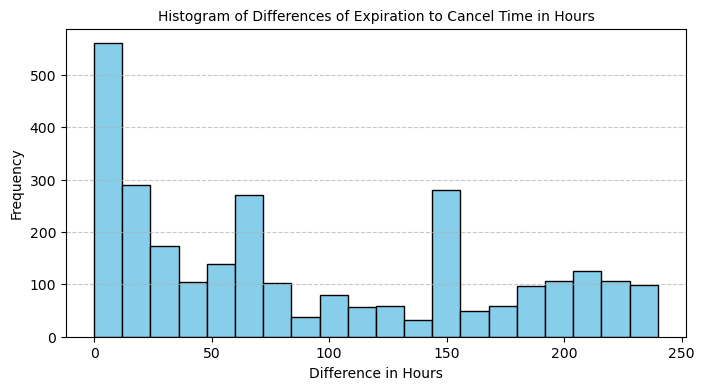

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plotting the histogram
plt.figure(figsize=(8, 4))
plt.hist(date_compare_df['diff'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Differences of Expiration to Cancel Time in Hours', fontsize=10)
plt.xlabel('Difference in Hours', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [67]:
atl_notam_df = filtered_df.drop(labels=["Location","NOTAM #", "Class", "Issue Date (UTC)", "Cancel Date (UTC)","Category", "Text", "Runway_ident"], axis = "columns")
atl_notam_df

,index,NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,08L/26R,08R/26L,09L/27R,09R/27L,10/28
0,28,01/01/2017,1729,01/02/2017,1729,0.0,0.0,0.0,1.0,0.0
1,29,01/01/2017,1728,01/02/2017,1728,0.0,0.0,1.0,0.0,0.0
2,30,01/01/2017,1726,01/02/2017,1726,0.0,1.0,0.0,0.0,0.0
3,31,01/01/2017,1725,01/02/2017,1725,1.0,0.0,0.0,0.0,0.0
4,32,01/01/2017,1722,01/02/2017,1722,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3563,16115,12/27/2017,0601,12/27/2017,0800,3.0,0.0,0.0,0.0,0.0
3564,16127,12/27/2017,0356,12/28/2017,2359,2.0,0.0,0.0,0.0,0.0
3565,16128,12/27/2017,0355,12/28/2017,2359,0.0,2.0,0.0,0.0,0.0
3566,16130,12/27/2017,0353,12/28/2017,2359,2.0,0.0,0.0,0.0,0.0


Lastly, the minutes are cut from the notam data since we are only interested in the hour they fall into.

In [68]:
atl_notam_df["NOTAM_Effective_Time"] = atl_notam_df["NOTAM_Effective_Time"].apply(lambda x: x[:2])
atl_notam_df["NOTAM_Expiration_Time"] = atl_notam_df["NOTAM_Expiration_Time"].apply(lambda x: x[:2])
atl_notam_df

,index,NOTAM_Effective_Date,NOTAM_Effective_Time,NOTAM_Expiration_Date,NOTAM_Expiration_Time,08L/26R,08R/26L,09L/27R,09R/27L,10/28
0,28,01/01/2017,17,01/02/2017,17,0.0,0.0,0.0,1.0,0.0
1,29,01/01/2017,17,01/02/2017,17,0.0,0.0,1.0,0.0,0.0
2,30,01/01/2017,17,01/02/2017,17,0.0,1.0,0.0,0.0,0.0
3,31,01/01/2017,17,01/02/2017,17,1.0,0.0,0.0,0.0,0.0
4,32,01/01/2017,17,01/02/2017,17,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3563,16115,12/27/2017,06,12/27/2017,08,3.0,0.0,0.0,0.0,0.0
3564,16127,12/27/2017,03,12/28/2017,23,2.0,0.0,0.0,0.0,0.0
3565,16128,12/27/2017,03,12/28/2017,23,0.0,2.0,0.0,0.0,0.0
3566,16130,12/27/2017,03,12/28/2017,23,2.0,0.0,0.0,0.0,0.0


In [17]:
atl_notam_df.to_pickle(os.path.join(OUTPUT_FOLDER, "06_notam.pkl"))